# Video Understanding with Qwen2.5-VL

In this notebook, we delve into the capabilities of the **Qwen2.5-VL** model for video understanding tasks. Our objective is to showcase how this advanced model can be applied to various video analysis scenarios, ranging from basic OCR to complex event detection and summarization.


### GPU Setup Notice

> ⚠️ This tutorial is designed to run on a **powerful NVIDIA RTX 3090 GPU**.  
> Due to high computational requirements, it **cannot be run on Colab T4**.  
> To access a suitable GPU, you can rent one via Vast.ai following this guide:  
> [How to Rent a GPU on Vast.ai](https://class.vision/blog/vast-ai-gpu-rental)

---

### [Setup]

We start by loading the pre-trained `Qwen2_5_VLForConditionalGeneration` model.  
This model has been fine-tuned on a diverse set of video understanding tasks, enabling it to generate detailed and accurate descriptions based on visual inputs.


In [2]:
!pip install -q torch transformers accelerate qwen-vl-utils

In [5]:
!pip install -q flash-attn --no-build-isolation

In [22]:
!pip install -q decord markdown bs4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

model_path = "Qwen/Qwen2.5-VL-7B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path,
    dtype=torch.bfloat16, 
    attn_implementation="flash_attention_2",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Load video frames and timestamps

In [2]:
import os
import math
import hashlib
import requests

from IPython.display import Markdown, display
import numpy as np
from PIL import Image
import decord
from decord import VideoReader, cpu


def download_video(url, dest_path):
    response = requests.get(url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"Video downloaded to {dest_path}")


def get_video_frames(video_path, num_frames=128, cache_dir='.cache'):
    os.makedirs(cache_dir, exist_ok=True)

    video_hash = hashlib.md5(video_path.encode('utf-8')).hexdigest()
    if video_path.startswith('http://') or video_path.startswith('https://'):
        video_file_path = os.path.join(cache_dir, f'{video_hash}.mp4')
        if not os.path.exists(video_file_path):
            download_video(video_path, video_file_path)
    else:
        video_file_path = video_path

    frames_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_frames.npy')
    timestamps_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_timestamps.npy')

    if os.path.exists(frames_cache_file) and os.path.exists(timestamps_cache_file):
        frames = np.load(frames_cache_file)
        timestamps = np.load(timestamps_cache_file)
        return video_file_path, frames, timestamps

    vr = VideoReader(video_file_path, ctx=cpu(0))
    total_frames = len(vr)

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    frames = vr.get_batch(indices).asnumpy()
    timestamps = np.array([vr.get_frame_timestamp(idx) for idx in indices])

    np.save(frames_cache_file, frames)
    np.save(timestamps_cache_file, timestamps)

    return video_file_path, frames, timestamps


def create_image_grid(images, num_columns=8):
    pil_images = [Image.fromarray(image) for image in images]
    num_rows = math.ceil(len(images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image


Inference function

In [3]:
def inference(video_path, prompt, max_new_tokens=2048, total_pixels=20480 * 28 * 28, min_pixels=16 * 28 * 28):
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"video": video_path, "total_pixels": total_pixels, "min_pixels": min_pixels},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs, video_kwargs = process_vision_info([messages], return_video_kwargs=True)
    fps_inputs = video_kwargs['fps']
    print("video input:", video_inputs[0].shape)
    num_frames, _, resized_height, resized_width = video_inputs[0].shape
    print("num of video tokens:", int(num_frames / 2 * resized_height / 28 * resized_width / 28))
    inputs = processor(text=[text], images=image_inputs, videos=video_inputs, fps=fps_inputs, padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]

#### 0. Describe the Videos


In [30]:
!wget https://github.com/Alireza-Akhavan/datasets_and_models/raw/refs/heads/main/barf.mp4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2025-09-01 13:14:19--  https://github.com/Alireza-Akhavan/datasets_and_models/raw/refs/heads/main/barf.mp4
Resolving github.com (github.com)... 140.82.121.4
connected. to github.com (github.com)|140.82.121.4|:443... 
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Alireza-Akhavan/datasets_and_models/refs/heads/main/barf.mp4 [following]
--2025-09-01 13:14:19--  https://raw.githubusercontent.com/Alireza-Akhavan/datasets_and_models/refs/heads/main/barf.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
200 OKequest sent, awaiting response... 
Length: 2337119 (2.2M) [application/octet-stream]
Saving to: ‘barf.mp4.1’

barf.mp4.1          100%[===================>]   2.23M  --.-KB/s    in 0.05s   

2025-09-01 13:14:20 (43.2 MB/s) - ‘barf.mp4.1’ saved [2337119/2337119]



In [25]:
video_url = "barf.mp4"
prompt = "این ویدیو را توضیح بده. احتمالا کدوم کشوره؟"

## Use a local HuggingFace model to inference.
video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

response = inference(video_path, prompt)
display(Markdown(response))

video input: torch.Size([10, 3, 1008, 560])
num of video tokens: 3600


این ویدیو نشان می‌دهد که خیابانی در یک منطقه شهری پوشیده از برف است. خودروها به طور معمول در ایران پارک شده‌اند و برخی از آنها با برف پوشیده شده‌اند. همچنین، سرعت مجاز بر روی علامت راهنمایی مشخص شده است که در ایران معمولاً به صورت "10" و "30" نوشته می‌شود.

بنابراین، احتمالاً این ویدیو در ایران ضبط شده است.

#### 1. Reading Text in Videos

In this section, we demonstrate how the model can be used to recognize and summarize text within a video. Specifically, we'll use a video containing various products and ask the model to summarize their characteristics in a structured format.


In [ ]:
!wget -q https://github.com/Alireza-Akhavan/datasets_and_models/raw/refs/heads/main/llm.mp4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
video_url = "llm.mp4"
prompt = "ویژگی های این دوره را در یک جدول خلاصه کن"

## Use a local HuggingFace model to inference.
video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

response = inference(video_path, prompt)
display(Markdown(response))

video input: torch.Size([86, 3, 812, 448])
num of video tokens: 19952


برای خلاصه ویژگی‌های دوره LLM (Large Language Model) در یک جدول، می‌توانید به صورت زیر عمل کنید:

| ویژگی | توضیح |
|--------|-------|
| خالق مدل‌های هوش مصنوعی | این دوره برای خلق مدل‌های هوش مصنوعی طراحی شده است. |
| دسترسی به Chat GPT | دسترسی به ابزار قدرتمند Chat GPT برای تمرین و آموزش فراهم شده است. |
| حفظ حریم خصوصی | تأکید بر حفظ حریم خصوصی و امنیت داده‌ها در طول دوره. |
| عملکرد آنلاین و اینترنتی | عملکرد در محیط‌های آنلاین و اینترنتی ارزیابی می‌شود. |
| ارتباط با دیگران | ارتباط با دیگران برای مشاوره و گرفتن نظرات از طریق پلتفرم‌های آموزشی امکان‌پذیر است. |
| محتوای متنوع | محتوای متنوع و متنوع در طول دوره تغییر می‌کند. |
| تمرین و عملیات | تمرین و عملیات عملی در طول دوره انجام می‌شود. |
| ارائه مفاهیم پیشرفته | مفاهیم پیشرفته در حوزه هوش مصنوعی به طور کامل آموزش داده می‌شوند. |
| پیاده‌سازی و توسعه | پیاده‌سازی و توسعه مدل‌های هوش مصنوعی در طول دوره انجام می‌شود. |

این جدول شامل مهمترین ویژگی‌های دوره LLM است که در آن آموزش داده می‌شود.

In [5]:
video_url = "https://duguang-labelling.oss-cn-shanghai.aliyuncs.com/qiansun/video_ocr/videos/50221078283.mp4"
prompt = "لطفاً ویژگی‌های محصولات موجود در ویدئو را در قالب یک جدول خلاصه کنید."

## Use a local HuggingFace model to inference.
video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

response = inference(video_path, prompt)
display(Markdown(response))

video input: torch.Size([58, 3, 532, 980])
num of video tokens: 19285


براساس تصاویر و توضیحات در ویدئو، می‌توانیم یک جدول خلاصه از ویژگی‌های محصولات موجود در ویدئو را به شرح زیر آماده کنیم:

| ویژگی | توضیح |
|--------|-------|
| نوع محصول | جعبه‌های پلاستیکی |
| انواع محصولات | میوه‌ها (مانند هلو، توت فرنگی، انگور، توت، هندوانه) |
| طراحی | دارای دکمه‌های ساده و کاربردی |
| امنیت | بازدارنده علایق و حفاظت از محصولات داخل جعبه |
| کیفیت | ساخته شده از مواد پلاستیکی کیفیت بالا (PET) |
| مقاومت | مقاوم به ضربه و نفوذ، مناسب برای حمل و نقل |
| ظاهر | دارای نمای زیبا و شفاف، بدون بو و طعم |
| کاربرد | مناسب برای ذخیره‌سازی و نمایش محصولات میوه‌ای |

این جدول شامل مهمترین ویژگی‌های محصولات موجود در ویدئو است.

#### 2. Long Video Understanding

Next, we explore the model's capability to comprehend extremely long videos, such as those lasting up to one hour. This demonstrates how the model can effectively process and analyze extended video content, extracting meaningful insights over longer durations.

To reduce the number of visual tokens generated from a long video, you can specify the `resized_height` and `resized_width` parameters. These settings allow the video frames to be resized to a smaller dimension, effectively decreasing the computational load while maintaining the essential visual information needed for analysis.


In [13]:
video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/evaluations/data/LVBench/videos/GcRKREorGSc.mp4"
prompt = "Could you go into detail about the content of this long video?"

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

response = inference(video_path, prompt)
display(Markdown(response))


video input: torch.Size([768, 3, 140, 252])
num of video tokens: 17280


The video is a breathtaking journey through the diverse landscapes and wildlife of Botswana, showcasing the beauty and majesty of the African savanna. The narrative unfolds with sweeping panoramic views of the vast, open plains under a sky dotted with fluffy white clouds, setting the stage for an exploration of the region's rich biodiversity.

As the camera pans across the savanna, viewers are introduced to a vibrant ecosystem teeming with life. The lush greenery contrasts beautifully with the golden hues of the grasslands, creating a picturesque backdrop for the myriad species that call this place home. The video captures the essence of the African wilderness, where nature's grandeur is on full display.

Throughout the video, we see a variety of animals in their natural habitats. A lion, with its regal presence, is seen resting under a tree, while a cheetah prowls the open plains, ready to pounce. The graceful movements of antelopes and gazelles as they graze or engage in playful interactions highlight the harmony of the savanna ecosystem. Birds, including vultures and eagles, soar gracefully above, adding to the dynamic tapestry of life in this environment.

The video also features moments of tranquility, such as a lion lounging by a watering hole, surrounded by zebras and other herbivores. These scenes underscore the peaceful coexistence of different species within the savanna. The presence of elephants, both in their majestic strolls and in their interactions with the environment, adds another layer of depth to the narrative, emphasizing the interconnectedness of all life forms.

As the sun sets, casting a warm glow over the landscape, the video captures the serene beauty of the evening, with the silhouettes of trees and animals against the vibrant sky. This transition from day to night provides a stunning conclusion to the visual journey, leaving viewers with a profound appreciation for the natural world.

Overall, the video is a testament to the splendor of Botswana's wildlife and the awe-inspiring beauty of its savanna landscapes. It invites viewers to immerse themselves in the raw, untamed essence of Africa, offering a glimpse into a world where nature thrives in its most pristine form.

#### 3. Video Grounding

This part focuses on answering specific questions about a video segment. We specify a textual query and ask the model what is the period that the described content occur in the video, showcasing the model's ability to understand timestamps and search the detailed queries.

Video downloaded to .cache/6949e7065425b86c463a4c8fb6abf98e.mp4


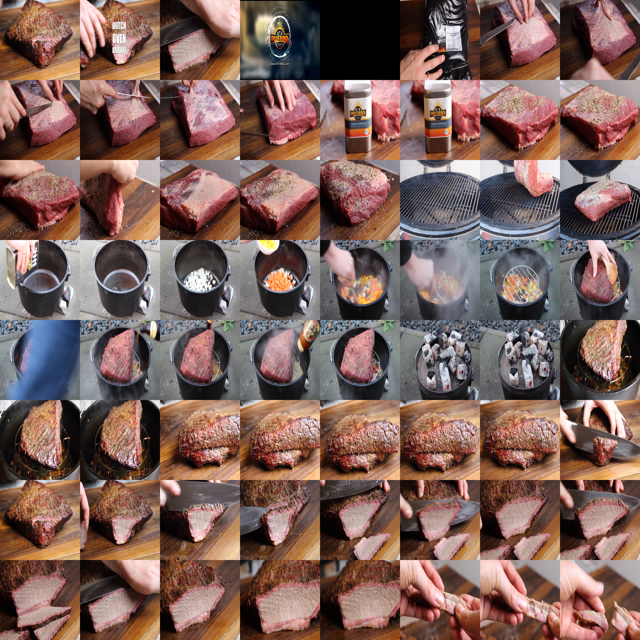

video input: torch.Size([530, 3, 168, 308])
num of video tokens: 17490


The query "seasoning the steak" occurs around 68.0 - 75.4 seconds in the video.

In [14]:
video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/datasets/cookbook/ead2e3f0e7f836c9ec51236befdaf2d843ac13a6.mp4"
prompt = "Give the query: 'seasoning the steak', when does the described content occur in the video?"

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
image_grid = create_image_grid(frames, num_columns=8)
display(image_grid.resize((640, 640)))

# inference
response = inference(video_path, prompt)
display(Markdown(response))

In [15]:
prompt = "Give the query: 'The seasoned meat is placed on a grill', when does the described content occur in the video? Use ‘mm:ss.ff’ as time format."

# inference
response = inference(video_path, prompt)
display(Markdown(response))

video input: torch.Size([530, 3, 168, 308])
num of video tokens: 17490


The event happens in 01:38.40 - 01:42.60.

#### 4. Structured Video Captioning

Finally, we present a scenario where the model identifies significant events within the video, providing start and end timestamps for each event along with descriptive sentences. The output is formatted in JSON for easy parsing and further processing.


In [17]:
video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/datasets/cookbook/ead2e3f0e7f836c9ec51236befdaf2d843ac13a6.mp4"
prompt = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. Provide the result in json format with 'mm:ss.ff' format for time depiction."

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

In [18]:
# inference
response = inference(video_path, prompt)
display(Markdown(response))

video input: torch.Size([530, 3, 168, 308])
num of video tokens: 17490


```json
[
    {
        "start_time": "00:00.00",
        "end_time": "00:25.40",
        "description": "A person is slicing a piece of meat on a cutting board."
    },
    {
        "start_time": "00:26.50",
        "end_time": "01:37.80",
        "description": "The person then seasons a large piece of meat with salt and pepper."
    },
    {
        "start_time": "01:39.00",
        "end_time": "02:44.20",
        "description": "Next, they put the meat on a grill and add vegetables to a pot."
    },
    {
        "start_time": "02:45.40",
        "end_time": "03:59.80",
        "description": "After cooking, they slice the meat into pieces."
    }
]
```

- By post-processing the json results, we can intuitively present video clips and descriptions in an interleaved manner.

In [23]:
import json
import markdown
from bs4 import BeautifulSoup
from datetime import datetime


def parse_json(response):
    html = markdown.markdown(response, extensions=['fenced_code'])
    soup = BeautifulSoup(html, 'html.parser')
    json_text = soup.find('code').text

    data = json.loads(json_text)
    return data


def time_to_seconds(time_str):
    time_obj = datetime.strptime(time_str, '%M:%S.%f')
    total_seconds = time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1_000_000
    return total_seconds


**00:00.00 - 00:25.40:**		A person is slicing a piece of meat on a cutting board.

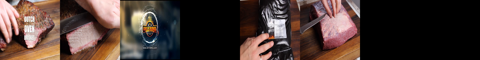

**00:26.50 - 01:37.80:**		The person then seasons a large piece of meat with salt and pepper.

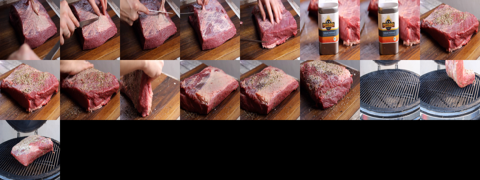

**01:39.00 - 02:44.20:**		Next, they put the meat on a grill and add vegetables to a pot.

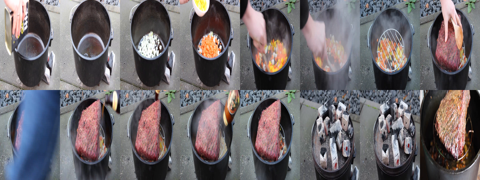

**02:45.40 - 03:59.80:**		After cooking, they slice the meat into pieces.

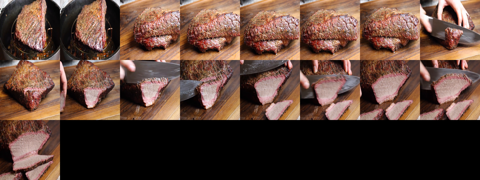

In [24]:
data = parse_json(response)

for item in data:
    start_time = item["start_time"]
    end_time = item["end_time"]
    description = item["description"]

    display(Markdown(f"**{start_time} - {end_time}:**\t\t" + description))

    start_time = time_to_seconds(start_time)
    end_time = time_to_seconds(end_time)
    current_frames = []
    for frame, timestamp in zip(frames, timestamps):
        if timestamp[0] > start_time and timestamp[1] < end_time:
            current_frames.append(frame)

    current_frames = np.array(current_frames)
    current_image_grid = create_image_grid(current_frames, num_columns=8)

    display(current_image_grid.resize((480, (int(len(current_frames) / 8) + 1) * 60)))


<div style="border: 2px solid #4A90E2; border-radius: 12px; padding: 15px; background-color: #F0F8FF; color: #333; font-family: 'Arial', sans-serif; text-align: center; box-shadow: 2px 2px 12px rgba(0,0,0,0.1);">
<strong>This notebook is based on <a href="https://github.com/QwenLM/Qwen2.5-VL" target="_blank" style="color:#4A90E2; text-decoration:none;">QwenLM</a> and has been slightly adapted by <a href="https://class.vision/" target="_blank" style="color:#4A90E2; text-decoration:none;">class.vision</a> for teaching purposes.</strong>
</div>
